## Introduction

Continuous Normalizing Flows (CNFs) are a class of generative models that learn to transform a simple base distribution (like a Gaussian) into a complex target distribution through continuous-time dynamics. Unlike discrete normalizing flows that use a finite sequence of invertible transformations, CNFs model the transformation as a continuous ordinary differential equation (ODE). CNFs are by definition invertible, regardless of the particular architecture used to model the velocity field.


A CNF defines a continuous transformation from time $t=0$ to $t=1$:

$$\frac{dx_t}{dt} = v_\theta(x_t, t)$$

where:
- $x_t \in \mathbb{R}^d$ is the state at time $t$
- $v_\theta(x_t, t)$ is a neural network (velocity field) parameterized by $\theta$
- The initial condition is $x_0 \sim p_0$ (base distribution, typically Gaussian)

For continuous transformations, the change of variables formula becomes:

$$\log p_1(x_1) = \log p_0(x_0) - \int_0^1 \text{div}(v_\theta(x_t, t)) \, dt$$

where $\text{div}(v_\theta(x_t, t))$ is the divergence of the velocity field.



## Key Advantages of CNFs

1. **Invertibility**: The transformation is naturally invertible through the ODE, regardless of the particular models' architecture
2. **Exact Likelihood**: Can compute exact log-likelihoods 



In [ ]:
# Install required packages
%pip install torch torchvision torchaudio
%pip install torchdiffeq
%pip install matplotlib
%pip install numpy
%pip install tqdm
%pip install ipython


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/florpi/heidelberg_generative_lectures/blob/solutions/2_cnfs.ipynb)

Let's try CNFs on the two moon problem!

In [1]:
import torch
import torch.utils.data as data

import matplotlib.pyplot as plt

In [2]:
def two_moons(n: int, sigma: float = 5e-2):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(16384)

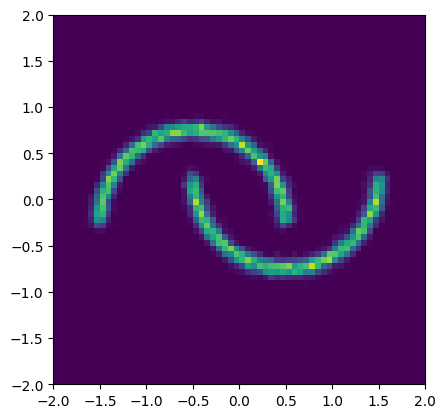

In [3]:

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()


## Velocity Network Implementation

The velocity network is the core component of our CNF. It learns to predict the velocity field $v_\theta(x_t, t)$ that defines how particles move through the state space.

The network architecture follows the pattern:
$$\text{Input: } (x_t, y_t, t) \rightarrow \text{Hidden Layers} \rightarrow \text{Output: } (v_x, v_y)$$

In [4]:
from torchdiffeq import odeint
from torch import nn
import torch

In [5]:

class VelocityNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # TODO: Create a neural network that takes as input:
        # - 2D position (x_t): 2 dimensions  
        # - 1D time (t): 1 dimension
        # Total input: 3 dimensions
        # 
        # Output: 2D velocity vector
        #
        # Store this in self.net as a nn.Sequential
        
        #self.net = # Your code here
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),  # 2D position + 1D time
            nn.SiLU(),  # Smooth activation function
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)  # Output 2D velocity
        )

    def forward(self, xt, t):
        # TODO: Combine xt and t into a single input tensor and pass it through the 
        # velocity prediction network
        if t.dim() == 1:
            t = t.unsqueeze(1)
        xt = torch.cat([xt, t], dim=1)
        v = self.net(xt)
        return v

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

x1, _  = two_moons(500)
x1 = x1.to(device).float()  # Move to device and convert to float

velocity_nn = VelocityNetwork(
    hidden_dim=256,
).to(device)
t = torch.full((500,), 0.5, dtype=torch.float32, device=device)

assert velocity_nn(
    xt=x1,
    t=t,
).shape == (500, 2), "Expected shape (500, 2) but got different shape"

Using device: cpu




## Divergence Computation

The divergence of the velocity field is crucial for computing the change in probability density. For a 2D velocity field $v = (v_x, v_y)$, the divergence is:

$$\text{div}(v) = \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}$$

**Why is divergence important?**
- It measures how much the velocity field "spreads out" or "converges" at each point
- Positive divergence: flow is expanding (probability density decreases)
- Negative divergence: flow is contracting (probability density increases)
- The integral of divergence over time gives the total change in log-probability

**Implementation details:**
- We use PyTorch's automatic differentiation to compute partial derivatives
- The `retain_graph=True` option allows us to compute gradients of gradients
- We sum over all spatial dimensions to get the total divergence

In [ ]:
def compute_div(y, x):
    # TODO: Implement the divergence of a vector field y, respect to x
    div = 0.0
    with torch.enable_grad():
        x.requires_grad_(True)
        for i in range(y.shape[-1]):
            div += torch.autograd.grad(
                y[..., i], x, torch.ones_like(y[..., i]), retain_graph=True,  create_graph=True,
            )[0][..., i : i + 1]
        return div

Let's test your implementation with an analytical solution, for the function $v(x, y) = (x^3, y^3)$

In [60]:
test_inputs = torch.randn((10, 2), requires_grad=True)
test_outputs = test_inputs**3
        
div_result = compute_div(test_outputs, test_inputs).squeeze()
expected_div = (3 * test_inputs**2).sum(dim=-1)
assert torch.allclose(div_result, expected_div, atol=1e-6, rtol=1e-5)

Now it is important that we can compute the gradients of the loss function, which can be tricky in pytorch since it requires second order differentiation. so you need to make sure the computational graph is kept so that we can differentiate it again (hint, checkout create_graph in torch.autograd.grad). This will use more memory, but it's crucial to be able to differentiate again.

In [61]:
with torch.enable_grad():
    test_inputs = torch.randn((10, 2), requires_grad=True)
    test_outputs = test_inputs**3
    div_result = compute_div(test_outputs, test_inputs).squeeze()

    # Now let's compute a dummy loss and differentiate it again
    loss = (div_result**2).mean()
    loss.backward()
    actual_grad_x = test_inputs.grad[:, 0]


    N = test_inputs.size(0)
    expected_grad_x = (12 / N) * div_result.detach() * test_inputs[:, 0]
            
    assert torch.allclose(actual_grad_x, expected_grad_x, atol=1e-4, rtol=1e-3)

## Training Process

The training loop implements maximum likelihood estimation for the CNF:

### Loss Function
We minimize the negative log-likelihood:
$$\mathcal{L}(\theta) = -\mathbb{E}_{x \sim p_{\text{data}}}[\log p_1(x)]$$

To compute $\log p_1(x_1)$, we solve a joint ODE that tracks both the state and the accumulated divergence:

$$\frac{d}{dt}\begin{bmatrix} x_t \\ \log p_t(x_t) \end{bmatrix} = \begin{bmatrix} v_\theta(x_t, t) \\ -\text{div}(v_\theta(x_t, t)) \end{bmatrix}$$


The explicit loss function is:

$$\mathcal{L}(\theta) = -\mathbb{E}_{x \sim p_{\text{data}}}[\log p_0(x_0) - \int_0^1 \text{div}(v_\theta(x_t, t)) \, dt]$$



In [62]:
import numpy as np

def compute_log_prior(x0):
    # TODO: write down the log prior for x0, our base distribution
    N = x0.shape[1]
    return -N / 2.0 * np.log(2 * np.pi) - torch.sum(x0**2, dim=1) / 2.0

In [71]:

import math

class ContinuosTimeFlow(nn.Module):
    def __init__(self, velocity_network, device='cpu'):
        super().__init__()
        self.velocity_net = velocity_network
        self.device = device


    def sample(self, target_shape=(2,), num_samples=10,):
        #TODO: Solve the sampling ode starting from x0, and return the final state x1 (hint odeint from torchdiffeq could be your friend)
        x_0 = torch.randn(num_samples, *target_shape, device=self.device)
        batch_size = x_0.shape[0]
        _, x_1 = odeint(
            lambda t, x_t: self.velocity_net(x_t, torch.full((batch_size,), t.item(), device=x_t.device, requires_grad=False)),
            x_0,
            torch.tensor([.0, 1.0], dtype=torch.float32, device=self.device),
            atol=1e-5,
            rtol=1e-5,
            method="dopri5",
        )
        return x_1

    def rhs_of_joint_ode(self, t, x_t_div_t,):
        # TODO: Implement the right hand side of the joint ode needed for sampling p(x)
        batch_size = x_t_div_t.shape[0]
        x_t = x_t_div_t[:, :-1].detach()
        t = t.detach()
        with torch.enable_grad():
            x_t.requires_grad_(True)
            t_batch = torch.full((batch_size,), t.item(), device=x_t.device, requires_grad=False)
            v_t = self.velocity_net(x_t, t_batch)
            div_vt = compute_div(v_t, x_t)
        
        return torch.cat((v_t, -div_vt), dim=1)
            
    def log_prob(self, x):
        # TODO: Implement the log probability of the flow
        x = x.to(self.device)
        x_div_initial = torch.cat(
            (x, torch.zeros((x.shape[0],), device=self.device).unsqueeze(1)),
            dim=1,
        ) 
        _, x_and_div = odeint(
            lambda t, x_t_div_t: self.rhs_of_joint_ode(
                t, x_t_div_t, 
            ),
            x_div_initial,
            torch.tensor([1.0, 0.0], dtype=torch.float32, device=self.device),
            atol=1e-5,
            rtol=1e-5,
            method="dopri5",
        )
        x0, int_divergence = x_and_div[:, :-1], x_and_div[:, -1]
        log_prior = compute_log_prior(x0)

        return (log_prior  - int_divergence)



In [72]:
flow = ContinuosTimeFlow(velocity_nn, device=device)

In [73]:
logp = flow.log_prob(x1)

# let's make sure you are returning a scalar value for each example in the batch
assert logp.shape == (x1.shape[0],)

In [74]:
from tqdm import tqdm
import torch.optim as optim
from IPython.display import clear_output


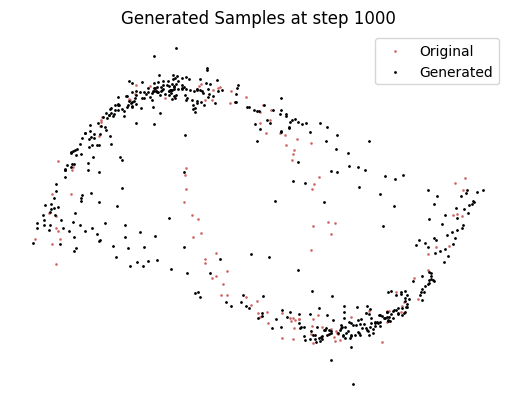

Training: 100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s, Loss=1.1549]


In [75]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=1.e-4, weight_decay=1e-4)
total_steps = 1_000
generate_every = 100
batch_size = 128
losses = []

flow.train()

step = 0 
with tqdm(total=total_steps, desc="Training") as pbar:
    while step < total_steps:
        x, label = two_moons(batch_size)
        x = x.to(device)  # Move data to device
        loss = -flow.log_prob(x).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=1.0)


        optimizer.step()
        optimizer.zero_grad()


        pbar.set_postfix({
                'Loss': f'{loss:.4f}',
            })
        pbar.update(1)
        step += 1
        losses.append(loss.detach())
        if step % generate_every == 0:
            flow.velocity_net.eval()
            print('x = ', x.shape)
            print(f"\nGenerating samples at step {step}...")
            
            samples = flow.sample(
                num_samples=500, 
            ).detach().cpu().numpy()
            clear_output(wait=True)
            plt.scatter(
                x[:,0].cpu().numpy(),
                x[:,1].cpu().numpy(),
                c='indianred',
                s=1,
                alpha=0.8,
                label='Original'
            )
            plt.scatter(
                samples[:,0],
                samples[:,1],
                c='k',
                s=1,
                label='Generated'
            )
            plt.legend()
            plt.title(f'Generated Samples at step {step}')
            plt.axis('off')
 
            plt.show()
            flow.velocity_net.train()

    losses = torch.stack(losses)




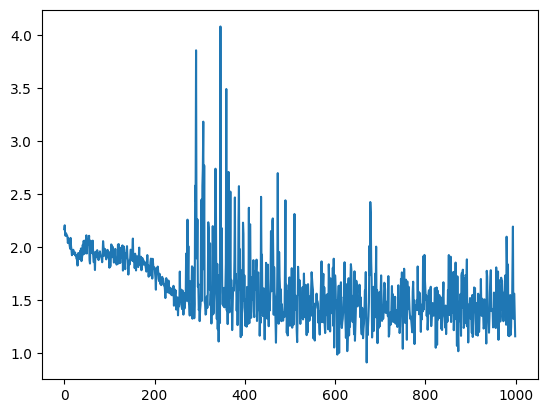

In [76]:
plt.plot(losses)